<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/%ED%98%84%EB%8C%80%EC%B0%A8_%ED%86%B5%ED%95%A9%ED%85%8C%EC%9D%B4%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘 시작

## 라이브러리 설치

In [1]:
!pip install finance-datareader
!pip install pykrx
!pip install pymysql
!pip install konlpy
from konlpy.tag import Okt
okt = Okt()

     |████████████████████████████████| 70 kB 3.7 MB/s 
     |████████████████████████████████| 60 kB 5.2 MB/s 
     |████████████████████████████████| 251 kB 19.6 MB/s 
     |████████████████████████████████| 43 kB 1.1 MB/s 
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 448 kB 44.6 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


## 패키지 & 함수 로딩

In [2]:
# 필요 라이브러리
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 주식가격 로딩
import FinanceDataReader as fdr
from pykrx import stock

import datetime

In [3]:
def money_sur(stock_name, start, end):

    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')

    return data

In [4]:
def reverse_min_max_scaling(org_x, x): #종가 예측값
    org_x_np = np.asarray(org_x) 
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min())) + org_x_np.min()

## 통합테이블 생성

In [81]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
# total_table = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/total_table.csv') # 기존 테이블

In [83]:
# 구성
dic = {'code' : [],
       'date' : [],
       'lstm' : [],
       'arima' : [],
       'fbprophet' : [],
       'RL' : [],
    #    'mail_news' : [],
    #    'mail_news_nsi' : [],
    #    'asia_news' : [],
    #    'asia_news_nsi': [],
    #    'youtube_sam' : [],
    #    'youtube_su' : [],
    #    'youtube_han' : [],
       'close' : []}

total_table = pd.DataFrame(dic)

In [84]:
total_table.columns

Index(['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'close'], dtype='object')

In [85]:
total_table

,code,date,lstm,arima,fbprophet,RL,close


## LSTM 예측결과

### 사용 데이터 로드 및 전처리

In [86]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
lstm = money_sur('005380', '2018', end_date)

In [87]:
lstm = lstm.set_index('Date')

In [88]:
lstm.head()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
Date,,,,,,,,,,,,
2018-01-02,150500,153000,149000,149500,731763,-0.041667,235358,7.43,0.64,20118,2.68,4000
2018-01-03,149000,151000,149000,150500,450874,0.006689,235358,7.48,0.64,20118,2.66,4000
2018-01-04,150500,151000,146000,146500,931558,-0.026578,235358,7.28,0.62,20118,2.73,4000
2018-01-05,146000,149000,145500,149000,463695,0.017065,235358,7.41,0.63,20118,2.68,4000
2018-01-08,148500,151000,147500,151000,482619,0.013423,235358,7.51,0.64,20118,2.65,4000


In [89]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
lstm_sc = sc.fit_transform(lstm)

In [90]:
scale_cols = lstm.columns
lstm_sc_df = pd.DataFrame(lstm_sc, columns=[scale_cols], index=lstm.index)

In [91]:
lstm_sc_df.head()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
Date,,,,,,,,,,,,
2018-01-02,0.408734,0.376147,0.431877,0.414683,0.027945,0.207458,0.0,0.032241,0.468354,1.0,0.299587,1.0
2018-01-03,0.401374,0.366972,0.431877,0.419643,0.013725,0.369957,0.0,0.033541,0.468354,1.0,0.295455,1.0
2018-01-04,0.408734,0.366972,0.416452,0.399802,0.038059,0.258163,0.0,0.028341,0.443038,1.0,0.309917,1.0
2018-01-05,0.386654,0.357798,0.413882,0.412202,0.014374,0.404825,0.0,0.031721,0.455696,1.0,0.299587,1.0
2018-01-08,0.398921,0.366972,0.424165,0.422123,0.015332,0.392586,0.0,0.034321,0.468354,1.0,0.293388,1.0


In [92]:
for i in scale_cols:
  for s in range(1, 11):  
    lstm_sc_df[(i+'shift_{}'.format(s),)] = lstm_sc_df[(i,)].shift(s)

In [93]:
lstm_sc_df.dropna()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,Lowshift_5,Lowshift_6,Lowshift_7,Lowshift_8,...,PBRshift_1,PBRshift_2,PBRshift_3,PBRshift_4,PBRshift_5,PBRshift_6,PBRshift_7,PBRshift_8,PBRshift_9,PBRshift_10,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-16,0.423454,0.399083,0.452442,0.456845,0.013202,0.412520,0.000000,0.043162,0.506329,1.0,0.268595,1.0,0.425908,0.423454,0.435721,0.418548,0.411187,0.398921,0.386654,0.408734,0.401374,0.408734,0.385321,0.389908,0.392202,0.399083,0.373853,0.366972,0.357798,0.366972,0.366972,0.376147,0.442159,0.455013,0.449871,0.447301,0.434447,0.424165,0.413882,0.416452,...,0.493671,0.481013,0.493671,0.493671,0.481013,0.468354,0.455696,0.443038,0.468354,0.468354,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.278926,0.283058,0.278926,0.276859,0.287190,0.293388,0.299587,0.309917,0.295455,0.299587,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2018-01-17,0.440628,0.403670,0.467866,0.454365,0.009278,0.336844,0.000000,0.042642,0.506329,1.0,0.270661,1.0,0.423454,0.425908,0.423454,0.435721,0.418548,0.411187,0.398921,0.386654,0.408734,0.401374,0.399083,0.385321,0.389908,0.392202,0.399083,0.373853,0.366972,0.357798,0.366972,0.366972,0.452442,0.442159,0.455013,0.449871,0.447301,0.434447,0.424165,0.413882,...,0.506329,0.493671,0.481013,0.493671,0.493671,0.481013,0.468354,0.455696,0.443038,0.468354,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.268595,0.278926,0.283058,0.278926,0.276859,0.287190,0.293388,0.299587,0.309917,0.295455,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2018-01-18,0.443081,0.399083,0.457584,0.441964,0.007337,0.294138,0.000000,0.039262,0.493671,1.0,0.278926,1.0,0.440628,0.423454,0.425908,0.423454,0.435721,0.418548,0.411187,0.398921,0.386654,0.408734,0.403670,0.399083,0.385321,0.389908,0.392202,0.399083,0.373853,0.366972,0.357798,0.366972,0.467866,0.452442,0.442159,0.455013,0.449871,0.447301,0.434447,0.424165,...,0.506329,0.506329,0.493671,0.481013,0.493671,0.493671,0.481013,0.468354,0.455696,0.443038,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.270661,0.268595,0.278926,0.283058,0.278926,0.276859,0.287190,0.293388,0.299587,0.309917,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2018-01-19,0.430815,0.417431,0.460154,0.476687,0.023160,0.499243,0.000000,0.048362,0.531646,1.0,0.256198,1.0,0.443081,0.440628,0.423454,0.425908,0.423454,0.435721,0.418548,0.411187,0.398921,0.386654,0.399083,0.403670,0.399083,0.385321,0.389908,0.392202,0.399083,0.373853,0.366972,0.357798,0.457584,0.467866,0.452442,0.442159,0.455013,0.449871,0.447301,0.434447,...,0.493671,0.506329,0.506329,0.493671,0.481013,0.493671,0.493671,0.481013,0.468354,0.455696,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.278926,0.270661,0.268595,0.278926,0.283058,0.278926,0.276859,0.287190,0.293388,0.299587,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2018-01-22,0.467615,0.426606,0.480720,0.479167,0.020389,0.357851,0.000000,0.049142,0.531646,1.0,0.254132,1.0,0.430815,0.443081,0.440628,0.423454,0.425908,0.423454,0.435721,0.418548,0.411187,0.398921,0.417431,0.399083,0.403670,0.399083,0.385321,0.389908,0.392202,0.399083,0.373853,0.366972,0.460154,0.457584,0.467866,0.452442,0.442159,0.455013,0.449871,0.447301,...,0.531646,0.493671,0.506329,0.506329,0.493671,0.481013,0.493671,0.493671,0.481013,0.468354,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.256198,0.278926,0.270661,0.268595,0.278926,0.283058,0.278926,0.276859,0.287190,0

In [94]:
X_test = lstm_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_test = lstm_sc_df.dropna()[['Close']]

X_test= X_test.values
y_test = y_test.values

In [95]:
X_test

array([[0.42590775, 0.42345437, 0.4357213 , ..., 1.        , 1.        ,
        1.        ],
       [0.42345437, 0.42590775, 0.42345437, ..., 1.        , 1.        ,
        1.        ],
       [0.44062807, 0.42345437, 0.42590775, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.63935231, 0.67124632, 0.67615309, ..., 0.        , 0.        ,
        0.        ],
       [0.65161923, 0.63935231, 0.67124632, ..., 0.        , 0.        ,
        0.        ],
       [0.64180569, 0.65161923, 0.63935231, ..., 0.        , 0.        ,
        0.        ]])

In [96]:
X_test_t = X_test.reshape(X_test.shape[0], 10, 12)

### 모델 로드

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Flatten, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(LSTM(64,
               input_shape = (10, 12),
               return_sequences= True))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(LSTM(64,
               input_shape = (10, 12),
               return_sequences= True))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'tanh'))
model.add(LSTM(64,
               return_sequences = False))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))


lstm_path = '/content/drive/My Drive/Final PJT - 업빛투/Regression/LSTM/'
hun_lstm = 'lstm_hundai.h5'

model.load_weights(lstm_path+hun_lstm)

### 모델 결과

In [98]:
pred = model.predict(X_test_t)

In [99]:
pred.shape, y_test.shape

((915, 1), (915, 1))

In [100]:
pred_act = reverse_min_max_scaling(lstm['Close'], pred)

In [101]:
total_table['date'] = lstm.index[10:]
total_table['lstm'] = pred_act[:]
total_table['close'] = lstm.Close[10:].values.reshape(-1,1)
total_table['code'] = '005380'
total_table['change'] = lstm.Change[10:].values.reshape(-1,1)

In [102]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,005380,2018-01-16,135282.672119,NaN,NaN,NaN,158000,0.019355
1,005380,2018-01-17,137288.666630,NaN,NaN,NaN,157500,-0.003165
2,005380,2018-01-18,137463.437653,NaN,NaN,NaN,155000,-0.015873
3,005380,2018-01-19,137928.306103,NaN,NaN,NaN,162000,0.045161
4,005380,2018-01-22,138916.832733,NaN,NaN,NaN,162500,0.003086
...,...,...,...,...,...,...,...,...
910,005380,2021-09-28,198528.249168,NaN,NaN,NaN,201500,-0.012255
911,005380,2021-09-29,197831.760597,NaN,NaN,NaN,201500,0.000000
912,005380,2021-09-30,197023.460388,NaN,NaN,NaN,200000,-0.007444
913,005380,2021-10-01,196401.989555,NaN,NaN,NaN,193500,-0.032500


## arima 예측결과

In [103]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
samsung_df = money_sur('005380', '2015', end_date)

In [104]:
df = samsung_df[['Date','Close']]
df.columns = ['Date', 'Price']

In [105]:
len(total_table['arima'])

915

In [106]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
# 학습, 테스트 데이터 분리
for ru in range(-len(total_table),0):
    rus = ru+1
    train = df[:ru]
    test = df[ru:]

    if ru >= -10:
      model = ARIMA(train.Price.values, order = (2,1,2))
      model_fit = model.fit(trend = 'nc', full_output = True, disp = True)
    else:
      model = ARIMA(train.Price.values, order = (3,2,0))
      model_fit = model.fit(trend = 'nc', full_output = True, disp = True)

    fore = model_fit.forecast(steps=1) # 오늘 예측

    # 오늘 예측 데이터
    pred_arima_y = fore[0].tolist()

    # 실제 오늘 데이터 
    test_y = test.Price.values

    # # 신뢰구간
    # # 예측 데이터 최소값
    # pred_y_lower = []
    # # 예측 데이터 최대값
    # pred_y_upper = []

    # for lower_upper in fore[2]:
    #     lower = lower_upper[0]
    #     upper = lower_upper[1]
    #     pred_y_lower.append(lower)
    #     pred_y_upper.append(upper)
    if rus == 0:
        total_table['arima'].iloc[ru:] = pred_arima_y
    else:
        total_table['arima'].iloc[ru:rus] = pred_arima_y

print(model_fit.summary())

ValueError: ignored

In [54]:
total_table

,code,date,lstm,arima,fbprophet,RL,close


## fbprophet 예측

In [ ]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
samsung_df = money_sur('005380', start = '20180101', end = end_date)
df1 = samsung_df[['Date','Close']]
df1.columns = ['ds', 'y']

from fbprophet import Prophet

prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.6)

prophet.fit(df1)

# 10일단위로 예측값을 가져옴
future_data = prophet.make_future_dataframe(periods = 10, freq = 'd')
forecast_data = prophet.predict(future_data)

In [ ]:
list(total_table.date.values)

In [ ]:
total_table['fbprophet'] = forecast_data[forecast_data['ds'].isin(list(total_table.date.values))]['yhat'].values

In [ ]:
total_table

In [ ]:
# total_table.to_csv('./total_table.csv', index =False)

## RL 결과

### 데이터 로딩 및 함수 로딩

In [ ]:
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

# 금융정보 조회하기
def dataset_loaderKR(stock_name, start, end, train_ratio=0.8):
    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')
    date_split = data.index[int(train_ratio*len(data))] 

    return data[:date_split], data[date_split:], date_split


# ENV 설정
class Environment1:
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs

    def step(self, act):
        reward = 0
        
        # action
        # 0: Idle
        # 1: 매수
        # 2: 매도
        if act == 1: #매수
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # 매도
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

# MODEL
class Q_Network(nn.Module):
    def __init__(self,obs_len,hidden_size,actions_n):
        super(Q_Network,self).__init__()
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
    def forward(self,x):
        h = self.fc_val(x)
        return (h)

In [ ]:
(train, test, date_split) = dataset_loaderKR('005380', start = '2000', end = end_date)

### 모델 로딩 및 결과

In [ ]:
rl_path = '/content/drive/My Drive/Final PJT - 업빛투/Regression/RL/현대차_결과/'
hun_rl = 'hyundai_rl_재무정보.h5'

In [ ]:
# 모델 로딩
model = torch.load(rl_path+hun_rl)

test_env = Environment1(test)
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data)-1):
    pact = model(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    test_acts.append(pact.item())
            
    obs, reward, done = test_env.step(pact.numpy())
    test_rewards.append(reward)

    pobs = obs

# sell remaining stocks
profits = 0
for p in test_env.positions:
	profits += (test_env.data.iloc[test_env.t, :]['Close'] - p)

test_env.profits += profits
test_env.positions = []

test_profits = test_env.profits
pact = model(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
pact = np.argmax(pact.data)
next_action = pact.item()
test['Action'] = test_acts + [next_action]


print( )
print( test )
print( )
print("결과")
print( "손익결과 $%.2f" % round(test_profits,2) )
# 0: Idle
# 1: 매수
# 2: 매도

In [ ]:
test['Action'] = np.where(test['Action'] == 1,1,
                          np.where(test['Action'] == 2,-1,0))

In [ ]:
test['Action'][-10:]

In [ ]:
total_table['RL'] = test[test['Date'].isin(list(total_table.date.values))]['Action'].values

In [ ]:
total_table

## News 긍부정 결과
- '매일경제', '아시아경제'

In [ ]:
# corp_list = ['samsung', 'hyundai', 'lg', 'sk', 'celltrion'] 참고용
stock_num_list = ['005930', '005380', '051910', '000660', '068270']
news = ['maeil_news_craw', 'asia_news_craw']
start = (datetime.datetime.now() - datetime.timedelta(20)).strftime("%Y-%m-%d").replace('-','')
end = datetime.datetime.now().strftime("%Y-%m-%d").replace('-', '')

In [ ]:
# news_df = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/Final Data/1. samsung_score.csv') # 연습용

### 관련 함수 및 패키지 로드

In [ ]:
import pymysql
import sys
import re

In [ ]:
# 블로그에서 가져온 기본적인 한국어 긍부정 텍스트 목록
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/positive_words_self.txt', encoding='utf-8') as pos_blog:
    positive_blog = pos_blog.readlines()
positive_blog = [pos_blog.replace('\n', '') for pos_blog in positive_blog]
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/negative_words_self.txt', encoding='utf-8') as neg_blog:
    negative_blog = neg_blog.readlines()
negative_blog = [neg_blog.replace('\n', '') for neg_blog in negative_blog]

# KOSELF 감성 어휘 사전
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/KOSELF_pos.txt', encoding='utf-8') as pos:
    positive = pos.readlines()
positive = [pos.replace('\n', '') for pos in positive]
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/KOSELF_neg.txt', encoding='utf-8') as neg:
    negative = neg.readlines()
negative = [neg.replace('\n', '') for neg in negative]

In [ ]:
def news_db(news, stock):
    db = pymysql.connect(
            user='root', 
            passwd='1234', 
            host='3.35.70.166', 
            db='proj', 
            charset = 'utf8'
        )

    cursor = db.cursor(pymysql.cursors.DictCursor)
    news1 = news + '_news_craw'

    sql = "select * from {0}_{1} where length(date)=10".format(news1, stock)
    cursor.execute(sql)
    result = cursor.fetchall()

    # DataFrame으로 변경
    df = pd.DataFrame(result)

    db.close()

    df.rename(columns={'date': 'datetime'}, inplace=True)

    # DataFrame 형태를 통일하기 위해 date 컬럼 추가
    df['date'] = df['datetime'].str[0:4] + '-' + df['datetime'].str[4:6] + '-' + df['datetime'].str[6:8]
    df['date'] = pd.to_datetime(df['date'])

    # 결측치 제거 → 데이터 로드 시 완료했기 때문에 그다지 필요하지 않은 과정
    df = df.dropna()

    # 시간순으로 정렬
    df.sort_values('datetime', inplace=True)
    df.reset_index(inplace=True, drop=True)

    ### 4) Holidays
    db = pymysql.connect(user='root',
                         passwd='1234', 
                         host='3.35.70.166', 
                         db='proj',
                         charset='utf8')

    cursor = db.cursor(pymysql.cursors.DictCursor)

    # 4-1) 주말 및 공휴일 데이터
    sql = "select * from holidays"
    cursor.execute(sql)
    result = cursor.fetchall()

    holidays = pd.DataFrame(result)

    db.close()

    holidays['date'] = pd.to_datetime(holidays['date'])

    url = 'https://raw.githubusercontent.com/chaerui7967/stock_predict_news_and_youtube/master/Sentiment_Analysis/data/stopwords_ver1.txt'
    stopwords = list(pd.read_csv(url, header=None)[0])

    # Stop Words List에 각 매체명 추가
    except_media_list = ['매일경제', '매일', '경제', 'maeil', 'MK', 'mk',
                         '아시아경제', '아시아', 'Asia', 'ASIA', 'asia',
                         '삼프로TV', '삼프로', 'TV',
                         '슈카월드', '슈카', '월드'
                         '한국경제TV', '한국']
    for word in except_media_list:
        stopwords.append(word)
    
    #### 2. Preprocessing
    '''감성 어휘 사전 : negative / positive
       뉴스 데이터 : samsung / hyundai / lg / sk
       주식 데이터 : stock_samsung / stock_hyundai / stock_lg / stock_sk
       공휴일 데이터 : holidays'''
    
    
    ### 1) 뉴스 데이터 날짜 조정
    
    ## 1-1)업로드 시각 컬럼 추가
    df['time'] = df['datetime'].str[-2:]
    
    ## 1-2) 전일 15시 ~ 금일 15시로 날짜 조정
    after_market = ['15', '16', '17', '18', '19', '20', '21', '22', '23']

    for j in range(len(df['time'])):
        if df['time'][j] in after_market:
            df['date'][j] += datetime.timedelta(1)
        else:
            pass
    
    ## 1-3) 텍스트 전처리
    # \n, \t, \r 제거
    df['text'] = df['text'].str.replace('[\n|\t|\r]', '')
    df['text'] = df['text'].str.replace('\[|\]', '')
    df['text'] = df['text'].str.replace('\<.*\>', '')
    df['text'] = df['text'].str.replace('\\', '')
    df['text'] = df['text'].str.replace('이미지', '')


    ### 2) 주말 및 공휴일 제외
    
    ## 2-1) 주말 및 공휴일만 추출
    market_closed =holidays[holidays['holiday']=="O"].reset_index(drop=True)
    
    ## 2-3) 휴장일 List 생성
    market_closed_list = list(market_closed['date'])
    
    ## 2-4) iteration limit 조정
    limit_number = 15000
    sys.setrecursionlimit(limit_number)
    
    
    while len(df[df['date'].isin(market_closed_list)]['date']) != 0:
        for hoil in df[df['date'].isin(market_closed_list)]['date'].index:
            df['date'][hoil] += datetime.timedelta(1)
    
    ### 3) Tokenization 컬럼 추가
    
    df['Tokenization'] = 0
    rows = df.shape[0]
    for row in range(rows):
        hangeul = re.compile('[^ ㄱ-ㅣ 가-힣]')                                    # 정규 표현식 → 한글 추출 규칙 : 띄어쓰기(1개)를 포함한 한글
        result = hangeul.sub('', df['text'][row])   # 위에 설정한 hangeul 규칙을 text에 적용
        okt = Okt()                                                               # 형태소 추출
        nouns = okt.nouns(df['text'][row])
        nouns = [x for x in nouns if len(x) > 1]                                  # 한 글자 키워드 제거
        nouns = [x for x in nouns if x not in stopwords]                          # 불용어 제거
        
        corpus = " ".join(nouns)                                                  # List를 String으로 변환
        df['Tokenization'][row] = corpus


    # 점수 산출

    df['Positive_Score'] = 0
    df['Negative_Score'] = 0
    df['Ratio'] = 0.1
    df['Pred'] = 0
    df['NSI'] = 0.1
    
    for score in range(len(df)):
        pos_score = 0 ; neg_score = 0
        
        for token in range(len(df['Tokenization'][score].split())):
            if df['Tokenization'][score].split()[token] in positive:
                pos_score += 1
            elif df['Tokenization'][score].split()[token] in negative:
                neg_score += 1
            else:
                pass
        
        df['Positive_Score'][score] = pos_score
        df['Negative_Score'][score] = neg_score
        
        # 긍정과 부정의 비율
        if (pos_score==0) and (neg_score==0):
            df['Ratio'][score] = 0.5   # 둘 다 0일 경우에는 긍정으로 가정
        else:
            df['Ratio'][score] = pos_score / (pos_score + neg_score)
        
        # 예측 결과
        if df['Ratio'][score]>=0.5:
            df['Pred'][score] = 1
        else:
            df['Pred'][score] = -1
        
        # 뉴스심리지수(NSI) 계산
        if (pos_score==0) and (neg_score==0):
            df['NSI'][score] = 101
        else:
            df['NSI'][score] = (pos_score - neg_score) / (pos_score + neg_score) * 100 + 100
    
    return df

### 매일경제

In [ ]:
# mail_df = news_df[(news_df['news'] == '매일경제') & (news_df['st_cd'] == 5930)]

In [ ]:
mail_df = news_db('maeil', '005380')

In [ ]:
mail_df.head()

In [ ]:
mail_ratio = mail_df[mail_df['date'].isin(list(total_table.date.values))][['date','Ratio']]
mail_nsi = mail_df[mail_df['date'].isin(list(total_table.date.values))][['date','NSI']]

In [ ]:
mail_ratio = mail_ratio.groupby(['date']).mean().reset_index()
mail_nsi = mail_nsi.groupby(['date']).mean().reset_index()

In [ ]:
mail_ratio.columns = ['date', 'mail_news']
mail_nsi.columns = ['date', 'mail_news_nsi']

In [ ]:
total_table = pd.merge(total_table, mail_ratio, on='date', how='left')
total_table = pd.merge(total_table, mail_nsi, on='date', how='left')

In [ ]:
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news', 'mail_news_nsi', 'close', 'change']]

In [ ]:
total_table

### 아시아

In [ ]:
# asia_df = news_df[(news_df['news'] == '아시아경제') & (news_df['st_cd'] == 5930)]

In [ ]:
asia_df = news_db('asia', '005380')

In [ ]:
asia_df.tail()

In [ ]:
asia_ratio = asia_df[asia_df['date'].isin(list(total_table.date.values))][['date','Ratio']]
asia_nsi = asia_df[asia_df['date'].isin(list(total_table.date.values))][['date','NSI']]

asia_ratio = asia_ratio.groupby(['date']).mean().reset_index()
asia_nsi = asia_nsi.groupby(['date']).mean().reset_index()

asia_ratio.columns = ['date', 'asia_news']
asia_nsi.columns = ['date', 'asia_news_nsi']

In [ ]:
total_table = pd.merge(total_table, asia_ratio, on='date', how='left')
total_table = pd.merge(total_table, asia_nsi, on='date', how='left')

In [ ]:
# 컬럼 리셋
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news', 'mail_news_nsi', 'asia_news', 'asia_news_nsi', 'close', 'change']]

In [ ]:
total_table

In [ ]:
# total_table.to_csv('total_table.csv', index=False)

## youtube 긍부정 결과
- ['한국경제TV', '슈카월드', '삼프로TV_경제의신과함께']

In [ ]:
# # 이전 라벨링 데이터
# youtube_df = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/youtube_naver_labeling.csv')

In [ ]:
# youtube_df.ch_nm.unique()

### youtube 데이터 전체 로드

In [ ]:
def youtube_db():

    com_list = {'하이닉스' : '000660',
            '현대차' : '005380',
            '삼성전자' : '005930',
            'LG화학' : '051910',
            '셀트리온' : '068270'}
    media_list = {'youtube_한국경제_':'hk_',
                'youtube_삼프로_':'sampro_',
                'youtube_슈카_':'suka_'}
    df_list = []
    for n,m in media_list.items():
        for i,j in com_list.items():

            db = pymysql.connect(
                user='root', 
                passwd='1234', 
                host='3.35.70.166', 
                db='proj', 
                charset = 'utf8'
            )

            cursor = db.cursor(pymysql.cursors.DictCursor)
            sql = "select * from youtube_"+ m + j +" where length(date) = 10"
            
            cursor.execute(sql)

            result = cursor.fetchall()

            # 데이터 프레임으로 변경
            globals() ['df_'+ m + j ] = pd.DataFrame(result)
            print('df_'+ m + j)
            df_list.append(globals() ['df_'+ m + j ])
            
            db.close()
    
    # print(df_list)
    df_total = pd.concat(df_list)
    
    df_total.rename(columns={'date': 'datetime'}, inplace=True)
    # DataFrame 형태를 통일하기 위해 date 컬럼 추가
    df_total['date'] = df_total['datetime'].str[0:4] + '-' + df_total['datetime'].str[4:6] + '-' + df_total['datetime'].str[6:8]
    df_total['date'] = pd.to_datetime(df_total['date'])

    # 시간순으로 정렬
    df_total.reset_index(inplace=True, drop=True)

    ### 4) Holidays
    db = pymysql.connect(user='root',
                         passwd='1234', 
                         host='3.35.70.166', 
                         db='proj',
                         charset='utf8')

    cursor = db.cursor(pymysql.cursors.DictCursor)

    # 4-1) 주말 및 공휴일 데이터
    sql = "select * from holidays"
    cursor.execute(sql)
    result = cursor.fetchall()

    holidays = pd.DataFrame(result)
    db.close()

    holidays['date'] = pd.to_datetime(holidays['date'])

    ## 2-1) 주말 및 공휴일만 추출
    market_closed =holidays[holidays['holiday']=="O"].reset_index(drop=True)
    
    ## 2-3) 휴장일 List 생성
    market_closed_list = list(market_closed['date'])
    
    ## 2-4) iteration limit 조정
    limit_number = 15000
    sys.setrecursionlimit(limit_number)
    
    
    while len(df_total[df_total['date'].isin(market_closed_list)]['date']) != 0:
        for hoil in df_total[df_total['date'].isin(market_closed_list)]['date'].index:
            df_total['date'][hoil] += datetime.timedelta(1)

    # 간단한 전처리
    df_total['text'] = df_total['text'].str.replace('\[|\]','')
    df_total['text'] = df_total['text'].str.replace('[a-z]','')
    df_total['text'] = df_total['text'].str.replace('[A-Z]','')
    df_total['text'] = df_total['text'].str.replace('으','')
    df_total['text'] = df_total['text'].str.replace('음악','')
    df_total['text'] = df_total['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    df_total['text'] = df_total['text'].str.replace('^ +', "")

    return df_total

In [ ]:
df_total = youtube_db()

### 라벨링 패키지 및 모델 로딩

In [ ]:
# 라벨 훈련 데이터
X_train = []
aa = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/youtube/train_label.csv').drop('Unnamed: 0',1)
aa.x = aa.x.str.replace('\[|\]','')
aa.x = aa.x.str.replace("'","")
aa.x = aa.x.str.replace(" ","")

for i in aa.x:
    temp = i.split(',')
    X_train.append(temp)

In [ ]:
len(X_train)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
tokenizer = Tokenizer(19196)
tokenizer.fit_on_texts(X_train)
url = 'https://raw.githubusercontent.com/chaerui7967/stock_predict_news_and_youtube/master/Sentiment_Analysis/data/stopwords_ver1.txt'
stopwords = list(pd.read_csv(url, header=None)[0])

In [ ]:
max_len = 200

In [ ]:
# loaded_model = load_model('./best_model.h5')

In [ ]:
loaded_model = load_model('/content/drive/My Drive/Final PJT - 업빛투/감성분석/youtube/best_model.h5')

In [ ]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측

    if (score > 0.5):
        # print("{:.2f}% 확률로 긍정 리뷰\n".format(score * 100))
        return score, 1
    elif (score == 0.5):
        return score, 0
    else:
        # print("{:.2f}% 확률로 부정 리뷰\n".format((1 - score) * 100))
        return score, -1

In [ ]:
# sentiment_predict('꿀잼') 연습

### 삼프로

In [ ]:
sampro_df = df_total[(df_total.ch_nm == '삼프로TV_경제의신과함께') & (df_total.st_cd == '005380')]

In [ ]:
sampro_df = sampro_df[sampro_df.date.isin(total_table.date)]

In [ ]:
s_text = sampro_df.text.values

In [ ]:
scores = [] # 긍정 확률
for i in s_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [ ]:
len(sampro_df),len(scores)

In [ ]:
sampro_df['sampro_youtube'] = np.array(scores).reshape(-1,1)
sampro_score = sampro_df.groupby(['date']).mean().reset_index()[['date','sampro_youtube']]

In [ ]:
total_table = pd.merge(total_table, sampro_score, on='date',how='left')

In [ ]:
total_table

### 한국경제

In [ ]:
hk_df = df_total[(df_total.ch_nm == '한국경제TV') & (df_total.st_cd == '005380')]

In [ ]:
hk_df = hk_df[hk_df.date.isin(total_table.date)]

In [ ]:
hk_text = hk_df.text.values

scores = [] # 긍정 확률
for i in hk_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [ ]:
len(scores), len(hk_df)

In [ ]:
hk_df['hk_youtube'] = np.array(scores).reshape(-1,1)
hk_score = hk_df.groupby(['date']).mean().reset_index()[['date','hk_youtube']]

total_table = pd.merge(total_table, hk_score, on='date',how='left')

### 슈카월드

In [ ]:
su_df = df_total[(df_total.ch_nm == '슈카월드') & (df_total.st_cd == '005380')]

su_df = su_df[su_df.date.isin(total_table.date)]

su_text = su_df.text.values

scores = [] # 긍정 확률
for i in su_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [ ]:
len(su_df),len(scores)

In [ ]:
su_df['suka_youtube'] = np.array(scores).reshape(-1,1)
suka_score = su_df.groupby(['date']).mean().reset_index()[['date','suka_youtube']]

total_table = pd.merge(total_table, suka_score, on='date',how='left')

In [ ]:
total_table.columns

In [ ]:
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news',
       'mail_news_nsi', 'asia_news', 'asia_news_nsi',
       'sampro_youtube', 'hk_youtube', 'suka_youtube', 'close', 'change']]

# 최종결과

In [ ]:
total_table

In [ ]:
while total_table.iloc[-1:].isnull().sum().sum() != 0:
    if total_table.iloc[:1].isnull().sum().sum() != 0:
      for i in range(1, len(total_table)):
        total_table = total_table.fillna(method='pad')
      break
    total_table = total_table.fillna(method='pad')

In [ ]:
total_table

In [ ]:
total_table.to_csv('./total_table.csv', index=False)

In [ ]:
total_table = pd.read_csv('./total_table.csv')

# 하드보팅

In [ ]:
total_table_ud = np.round(total_table,2)


for i in range(len(total_table_ud)-1,0,-1):
  if total_table_ud['lstm'].iloc[i] > total_table_ud['lstm'].iloc[i-1]:
    total_table_ud['lstm'].iloc[i] = 1
  else:
    total_table_ud['lstm'].iloc[i] = -1
  
  if total_table_ud['arima'].iloc[i] > total_table_ud['close'].iloc[i-1]:
    total_table_ud['arima'].iloc[i] = 1
  else:
    total_table_ud['arima'].iloc[i] = -1
  
  if total_table_ud['fbprophet'].iloc[i] > total_table_ud['fbprophet'].iloc[i-1]:
    total_table_ud['fbprophet'].iloc[i] = 1
  else:
    total_table_ud['fbprophet'].iloc[i] = -1
  
total_table_ud['mail_news'] = np.where(total_table_ud['mail_news']>0.5,1,
                                       np.where(total_table_ud['mail_news']<0.5,-1,0))

total_table_ud['mail_news_nsi'] = np.where(total_table_ud['mail_news_nsi']>100,1,
                                       np.where(total_table_ud['mail_news_nsi']<100,-1,0))

total_table_ud['asia_news'] = np.where(total_table_ud['asia_news']>0.5,1,
                                       np.where(total_table_ud['asia_news']<0.5,-1,0))

total_table_ud['asia_news_nsi'] = np.where(total_table_ud['asia_news_nsi']>100,1,
                                       np.where(total_table_ud['asia_news_nsi']<100,-1,0))

total_table_ud['sampro_youtube'] = np.where(total_table_ud['sampro_youtube']>0.5,1,
                                       np.where(total_table_ud['sampro_youtube']<0.5,-1,0))

total_table_ud['hk_youtube'] = np.where(total_table_ud['hk_youtube']>0.5,1,
                                       np.where(total_table_ud['hk_youtube']<0.5,-1,0))

total_table_ud['suka_youtube'] = np.where(total_table_ud['suka_youtube']>0.5,1,
                                       np.where(total_table_ud['suka_youtube']<0.5,-1,0))

total_table_ud['change'] = np.where(total_table_ud['change']>0,1,
                                       np.where(total_table_ud['change']<0,-1,0))
total_table_ud.drop('close',1,inplace=True)

In [ ]:
total_table_ud

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,change
0,5380,2021-09-15,208400.87,209285.27,208127.22,-1,1,1,1,1,-1,1,1,0
1,5380,2021-09-16,-1.00,-1.00,-1.00,-1,1,1,1,1,-1,-1,1,-1
2,5380,2021-09-17,-1.00,1.00,-1.00,-1,1,1,1,1,-1,-1,1,0
3,5380,2021-09-23,-1.00,1.00,-1.00,-1,1,1,1,1,1,1,1,0
4,5380,2021-09-24,-1.00,-1.00,-1.00,1,-1,-1,-1,-1,-1,1,1,-1
5,5380,2021-09-27,1.00,-1.00,-1.00,-1,-1,-1,-1,-1,1,-1,1,-1
6,5380,2021-09-28,-1.00,1.00,-1.00,1,-1,-1,1,1,-1,-1,1,-1
7,5380,2021-09-29,-1.00,-1.00,-1.00,-1,1,1,-1,-1,-1,-1,1,0
8,5380,2021-09-30,-1.00,1.00,-1.00,1,1,1,1,1,1,-1,1,-1
9,5380,2021-10-01,-1.00,-1.00,-1.00,-1,-1,-1,1,1,-1,1,1,-1


In [ ]:
total_table_ud.to_csv('./hun_table_ud.csv', index=False)

# 로지스틱

In [ ]:
total_table.isnull().sum()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time
import joblib

logit = total_table.copy()
logit.dropna(inplace=True)
logit.drop('close',1,inplace=True)
logit['change'] = np.where(logit['change']>0,1,
                           np.where(logit['change']<0,-1,0))

# 회귀모델에서 b0를 위한 상수항 추가

logit = sm.add_constant(logit,has_constant = "add")
a=logit[logit['change'] == 0].index
logit = logit.drop(a)
logit = logit.reset_index().drop(['index'],1)
logit.head()

,const,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,change
0,1.0,343767.652482,332938.327427,314083.372057,-1,0.416667,83.476190,0.275238,55.047619,0.800389,0.827457,0.072400,-1
1,1.0,342534.304827,320818.597249,312548.683984,1,0.314286,62.857143,0.555556,111.111111,0.238027,0.827457,0.072400,1
2,1.0,343214.869678,321044.547989,309544.925421,1,0.428571,85.914286,0.571429,114.285714,0.238027,0.114109,0.901804,-1
3,1.0,343985.949785,318394.128853,310515.449954,0,0.441667,88.333333,0.250000,50.000000,0.238027,0.381141,0.901804,1
4,1.0,342758.369327,326121.652877,309649.086750,-1,0.600000,120.000000,0.833333,166.666667,0.238027,0.381141,0.901804,1


In [ ]:
cols = logit.columns.difference(["change",'code','date'])
X = logit[cols]
y = logit["change"]

train_x, test_x ,train_y, test_y = train_test_split(X, y, stratify=y,test_size=0.3,random_state=1)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(350, 12) (151, 12) (350,) (151,)


In [ ]:
model = LogisticRegression(random_state=1)
results = model.fit(train_x, train_y) # 다변수함수에 뉴턴방법을 적용한 로지스틱 회귀모형

In [ ]:
results.coef_

array([[ 2.34942790e-05, -1.06778188e-05, -2.47077916e-06,
        -4.59710381e-04,  5.55196646e-05,  1.79263872e-05,
         3.42278167e-07, -8.06354913e-06,  3.32095899e-05,
         6.65708875e-03, -4.17949363e-05,  3.55925958e-05]])

In [ ]:
# 아직 로지스틱의 log형태가 취해진 결과이기에 바로 확률로 해석하면 안된다. 
# np.exp(results.params)의 결과를 확인 필요
np.exp(results.coef_)

array([[1.00002349, 0.99998932, 0.99999753, 0.9995404 , 1.00005552,
        1.00001793, 1.00000034, 0.99999194, 1.00003321, 1.0066793 ,
        0.99995821, 1.00003559]])

In [ ]:
pred_y = results.predict_proba(test_x)
pred_y

array([-1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1,
        1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,
        1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1, -1, -1,  1, -1,  1, -1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1, -1, -1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1, -1,  1,  1, -1,  1,
        1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1, -1,  1,
       -1, -1, -1,  1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1, -1,
       -1,  1, -1, -1,  1, -1,  1,  1,  1,  1, -1,  1, -1,  1, -1])

In [ ]:
# 임계값 함수

def cut_off(y, threshold) :
    Y = []  # 대문자 Y를 새로운 변수로 하여 기존의 y값에 영향이 가지 않도록 한다.
    for i in range(len(y)):
      a = y[i][0]
      if a > threshold:
        Y.append(-1)
      else:
        Y.append(1)
    
    return np.array(Y)
  

pred_Y = cut_off(pred_y, 0.5)
pred_Y

array([-1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1,
        1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,
        1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1, -1, -1,  1, -1,  1, -1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1, -1, -1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1, -1,  1,  1, -1,  1,
        1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1, -1,  1,
       -1, -1, -1,  1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1, -1,
       -1,  1, -1, -1,  1, -1,  1,  1,  1,  1, -1,  1, -1,  1, -1])

In [ ]:
# confusion matrix (분류 표를 나타낸 행렬)

cfmat = confusion_matrix(test_y,pred_Y)
print(cfmat)

[[37 34]
 [22 58]]


In [ ]:
# confusion matrix accuracy(정확도) 계산함수

def acc(cfmat):
	return (cfmat[0,0] + cfmat[1,1])/(cfmat[0,0] + cfmat[1,1] + cfmat[0,1] + cfmat[1,0])
acc(cfmat)

0.6291390728476821

In [ ]:
# 임계값 0~1에 따른 정확도 확인

threshold = np.arange(0,1,0.1)
table = pd.DataFrame(columns = ['ACC'])
for i in threshold :
	pred_Y = cut_off(pred_y,i)
	cfmat = confusion_matrix(test_y,pred_Y)
	table.loc[i] = acc(cfmat)
table.index.name = "threshold"
table.columns.name = "performance"
table

performance,ACC
threshold,
0.0,0.629139
0.1,0.629139
0.2,0.629139
0.3,0.629139
0.4,0.629139
0.5,0.629139
0.6,0.629139
0.7,0.629139
0.8,0.629139


In [ ]:
pred_y = results.predict(test_x) # [-1,1]
pred_y

AUC: 0.6230633802816901


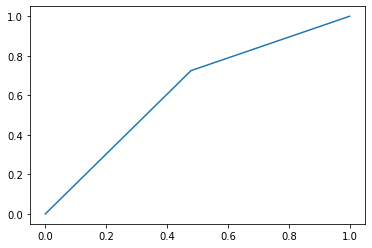

In [ ]:
# sklearn에서 ROC 패키지 활용
fpr, tpr, thresholds = roc_curve(test_y,pred_y,pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

In [ ]:
table_logit = logit[-10:]
table_logit['logit'] = pred_y[-10:]
ratio = results.predict_proba(test_x)[-10:] # [-1,1]
table_logit['up_ratio'] = 0.1
for i in range(10):
  table_logit['up_ratio'].iloc[i] = ratio[i][1]

In [ ]:
joblib.dump(results, 'logit_hun_model.pkl')

In [ ]:
table_logit.to_csv('hun_logit_table.csv', index=False)